In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import h5py
import sys
import corner
import copy
import scipy

from mpl_toolkits.mplot3d import Axes3D
from scipy.special import comb
from astropy import units as u

import analysis
import signals
import estimators
import fitting
import models
import utils

In [3]:
plt.style.use('seaborn-colorblind')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Simulations

In [4]:
box = h5py.File('halos.z8.hdf5', 'r')
box_old = h5py.File('L80_halos_z=6.0155.hdf5', 'r')

In [5]:
masses = np.array(box_old[('mass')])
pos = np.array(box_old[('pos')])
density = np.array(box_old[('rho')])
x, y, z = pos.T
coords = [x,y,z]

#x = np.array(box[('x')])
#y = np.array(box[('y')])
#z = np.array(box[('z')])

In [6]:
runs = 3
n_bins = 20

In [7]:
box_size = 80.0 # in Mpc
r = np.linspace(0, box_size, 512)
r_vec = np.stack((r, r, r))

In [8]:
mass_voxels, mass_edges = np.histogramdd(coords, bins=512,
                                                weights=masses)

In [9]:
n_voxels, n_edges = np.histogramdd(coords, bins=512)

In [10]:
n_bar = n_voxels / (box_size**3 / 512**3)
n_delta = utils.overdensity(n_bar)

Text(0, 0.5, '$\\frac{dN}{dLog(M)}$')

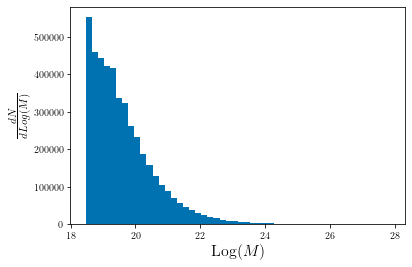

In [11]:
masses_hist = plt.hist(np.log(masses), bins=50)
plt.xlabel(r'Log$(M)$', fontsize=16)
plt.ylabel(r'$\frac{dN}{dLog(M)}$', fontsize=16)

In [12]:
delta = utils.overdensity(density)

In [13]:
k_log, density_pspec_log, density_pspec_dimless_log = analysis.calc_pspec(r_vec, [delta],
                                                        n_bins=n_bins, bin_scale='log')

matter_pspec_results = np.asarray([k_log, density_pspec_log, density_pspec_dimless_log])

voxel size is:  0.15655577299412915  Mpc
voxel volume is:  [0.00383714]  Mpc^3
survey volume is:  [515011.75700904]  Mpc^3
bin scale is: log
min resolution: k= 0.07853981633974483


### Checking power spectrum code with Powerbox

Let's check our power spectrum code to make sure it does what we expect. We'll compare it to the inimitable Steven Murray's Powerbox code.

In [14]:
from powerbox import get_power

p_k_field, bins_field = get_power(delta, box_size,
                                    bins=k_log, bin_ave=False,
                                    vol_normalised_power=True)

In [15]:
p_k_field_log, bins_field_log = get_power(delta, box_size, log_bins=True, bin_ave=False,
                                    vol_normalised_power=True)

/Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/powerbox/tools.py:106: UserWarning: One or more radial bins had no cells within it.
  warnings.warn("One or more radial bins had no cells within it.")
/Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/powerbox/tools.py:160: RuntimeWarning: invalid value encountered in true_divide
  rl = np.bincount(indx, weights=np.real(field.flatten()), minlength=len(sumweights)+2)[1:-1] / sumweights


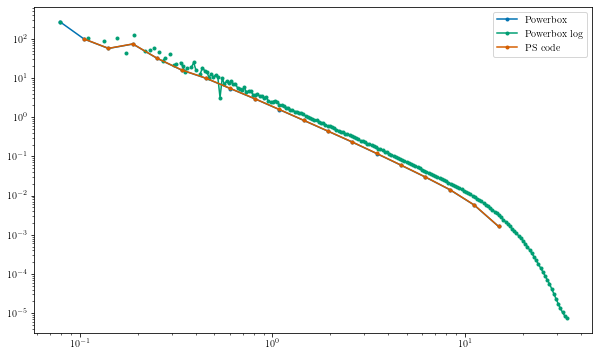

In [16]:
fig = plt.subplots(figsize=(10,6))

plt.plot(bins_field[:-1], p_k_field,label="Powerbox", marker='.')
plt.plot(bins_field_log[:-1], p_k_field_log, label="Powerbox log", marker='.', ls='-')
plt.plot(k_log[1:-1], density_pspec_log[1:-1],label="PS code", marker='.')

plt.legend()
plt.xscale('log')
plt.yscale('log')

In [17]:
k_log

array([ 0.07853982,  0.10513562,  0.14073752,  0.18839523,  0.25219119,
        0.33759028,  0.45190791,  0.60493672,  0.80978543,  1.08400171,
        1.45107539,  1.94245061,  2.60021941,  3.48072734,  4.6594002 ,
        6.23720508,  8.34929937, 11.17660861, 14.96132484, 20.02765317])

So our power spectra code is in good agreement with Steven Murray.  A reassuring sign!

### Comparison with CAMB and Powerbox

Now we need to make sure that our spectra our reasonable, compared to known results. Let's compare with the CAMB simulation code.

In [18]:
import sys, platform, os
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.2 installed at /Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/camb


In [19]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0);


In [20]:
#Now get matter power spectra and sigma8 at redshift 0 and 0.8
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(ns=0.965)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[6.0155], kmax=2.0)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=bins_field[0], maxkh=bins_field[-5],
                                              npoints=200)
s8 = np.array(results.get_sigma8())

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=bins_field[0],
                                                                   maxkh=bins_field[-5],
                                                                   npoints = 200)


In [21]:
#calculate results for these parameters
results = camb.get_results(pars)

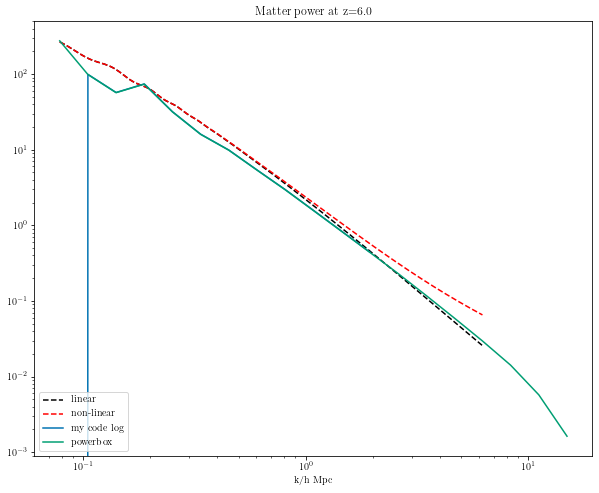

In [22]:
#for i, (redshift, line) in enumerate(zip(z,['-','--'])):
fig = plt.figure()

fig.set_figheight(8)
fig.set_figwidth(10)

plt.loglog(kh, pk[0,:], color='k', ls='--')
plt.loglog(kh_nonlin, pk_nonlin[0,:], color='r', ls='--')
    
#plt.loglog(k_log, density_pspec_log)
plt.loglog(k_log[0:12], density_pspec_log[0:12])
plt.loglog(bins_field[:-1], p_k_field)

plt.xlabel('k/h Mpc');
plt.legend(['linear','non-linear', 'my code log', 'powerbox'], loc='lower left');
plt.title('Matter power at z=6.0');

### Simulating the 21cm brightness temperature field

We also want to cross-correlate our intensities with the 21cm field.  In order to simulate it, we use Paul La Plante's 'quick and dirty' simulation code package <\code zreion>.

In [23]:
import h5py

from zreion import apply_zreion_fast

In [24]:
# parameters
box = 80.0  # Mpc/h
omegam = 0.315823
omegab = 0.049387
hubble0 = 0.673212

# global temperature as a function of redshift
def t0(z):
    return 38.6 * hubble0 * (omegab / 0.045) * np.sqrt(0.27 / omegam * (1 + z) / 10)

from numpy.random import default_rng
rng = default_rng()
density_rand = rng.standard_normal((64,64,64))

In [25]:
def gen_21cm_fields(delta, box = 80.0, zmean=7, alpha = 0.11, k0 = 0.05):
    # compute zreion field
    print("computing zreion...")
    zreion = apply_zreion_fast(delta, zmean, alpha, k0, box, deconvolve=False)
    
    return zreion

def get_21cm_fields(z, zreion):
    #print("computing t21 at z=", z, "...")
    ion_field = np.where(zreion > z, 1.0, 0.0)
    t21_field = t0(z) * (1 + delta) * (1 - ion_field)
    
    return ion_field, t21_field

In [26]:
zreion = gen_21cm_fields(delta)

computing zreion...


In [27]:
ion_field, t21_field = get_21cm_fields(7, zreion)

In [28]:
zreion1 = gen_21cm_fields(delta, alpha = 0.05, k0 = 0.3)
zreion2 = gen_21cm_fields(delta, alpha = 0.11, k0 = 0.05)
zreion3 = gen_21cm_fields(delta, alpha = 0.15, k0 = 0.1)
zreion4 = gen_21cm_fields(delta, alpha = 0.25, k0 = 0.07)
zreion5 = gen_21cm_fields(delta, alpha = 0.564, k0 = 0.185)

computing zreion...
computing zreion...
computing zreion...
computing zreion...
computing zreion...


In [29]:
redshifts = np.linspace(5,15)

def create_reion_history(redshifts, zreion):
    neutral_frac = np.zeros_like(redshifts)
    for i, z in enumerate(redshifts):
        ion_field, t21_field = get_21cm_fields(z, zreion)
        ion_frac = ion_field.sum() / 512**3
        neutral_frac[i] = 1 - ion_frac
        
    return neutral_frac

In [30]:
neutral_frac1 = create_reion_history(redshifts, zreion1)
neutral_frac2 = create_reion_history(redshifts, zreion2)
neutral_frac3 = create_reion_history(redshifts, zreion3)
neutral_frac4 = create_reion_history(redshifts, zreion4)
neutral_frac5 = create_reion_history(redshifts, zreion5)

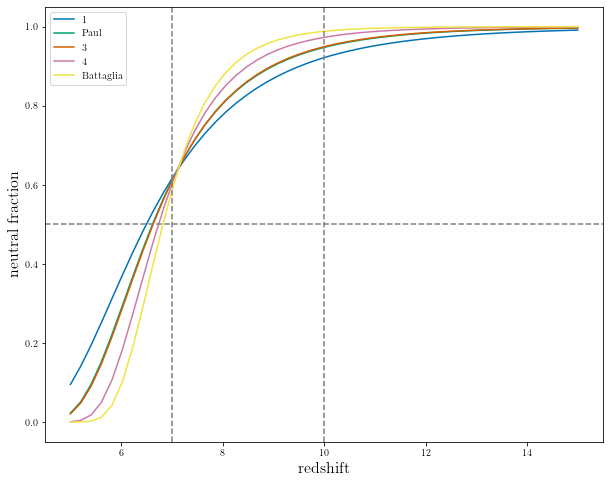

In [31]:
fig = plt.figure(figsize=(10,8))

plt.plot(redshifts, neutral_frac1, label='1')
plt.plot(redshifts, neutral_frac2, label='Paul')
plt.plot(redshifts, neutral_frac3, label='3')
plt.plot(redshifts, neutral_frac4, label='4')
plt.plot(redshifts, neutral_frac5, label='Battaglia')

plt.axhline(.5, color='gray', ls='--')
plt.axvline(7, color='gray', ls='--')
plt.axvline(10, color='gray', ls='--')

plt.xlabel('redshift', fontsize=16)
plt.ylabel('neutral fraction', fontsize=16)

plt.legend()

In [32]:
redshifts = np.linspace(5,15)

neutral_frac = np.zeros_like(redshifts)

for i, z in enumerate(redshifts):
    ion_field, t21_field = get_21cm_fields(z, zreion)
    ion_frac = ion_field.sum() / 512**3
    neutral_frac[i] = 1 - ion_frac

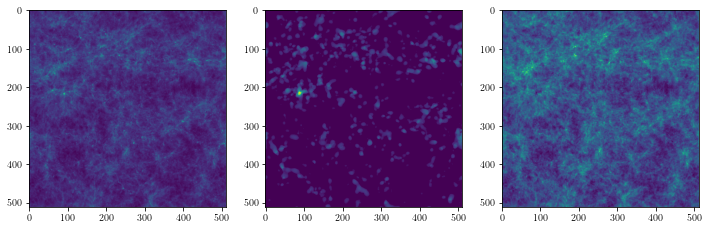

In [33]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1,3, figsize=(12,8))

ax[0].imshow(delta.sum(axis=2))
ax[1].imshow(ion_field.sum(axis=2))
ax[2].imshow(t21_field.sum(axis=2))

In [34]:
t21_field

array([[[20.87821579, 19.8807354 , 24.61730194, ..., 14.60887718,
         13.95740604, 17.49675941],
        [20.49813843, 17.0779171 , 23.99731064, ..., 22.11303902,
         17.97759819, 20.39933777],
        [25.62758636, 28.45209122, 32.03487015, ..., 32.23134232,
         28.04258919, 30.64514923],
        ...,
        [42.07934189, 50.18257141, 35.62301636, ..., 14.06861115,
         23.43689156, 31.38634109],
        [38.79772949, 38.50393677, 37.68002701, ..., 12.03614521,
         21.89849472, 32.89858627],
        [29.25756454, 26.05443001, 29.1928196 , ..., 11.80994415,
         14.62384319, 23.58955193]],

       [[25.24674225, 23.33889771, 27.83086777, ..., 20.54208374,
         19.23429298, 21.8787117 ],
        [23.22102737, 23.89685249, 26.57053947, ..., 31.32517624,
         27.02121353, 23.31451988],
        [28.22736359, 30.25855827, 26.84276772, ..., 45.5798111 ,
         37.17444229, 26.67421532],
        ...,
        [40.28733063, 39.22805405, 50.00233841, ..., 2

### Checking normalisation of luminosity functions 

Next we are going to need to generate some simulated specific intensities from our box our halos. This is done by 'painting' a luminosity onto the halos using a power law prescription,

$$
L(M) = L_0 \left( \frac{M}{M_0} \right)^{\alpha}
$$

Let's plot this relation for our collection our halos,

In [35]:
import astropy.constants as const
from astropy.cosmology import Planck15

In [37]:
utils.specific_intensity(6)

<Quantity 1339.75038019 Jy / sr>

In [38]:
utils.emissivity(6
                )

<Quantity 1858778.33436829 solLum / Mpc3>

In [40]:
luminosities_L[0]

<Quantity 1.14575484e+08 solLum2>

In [42]:
H_I_power = 1.3

z = 6.0

L = 2.0 / 3.0
M = 1.0
H = 4.0 / 3.0

power_indices = [H_I_power, L, M]

L_solar=3.828e26
L_CII = 10e6
L_OIII = 10e9

luminosities_L = utils.mass2luminosity(masses, power=L)
luminosities_M = utils.mass2luminosity(masses, power=M)
luminosities_H = utils.mass2luminosity(masses, power=H)

intensities_L = utils.specific_intensity(z, L=luminosities_L)
intensities_M = utils.specific_intensity(z, L=luminosities_M)
intensities_H = utils.specific_intensity(z, L=luminosities_H)

Text(0, 0.5, 'luminosities')

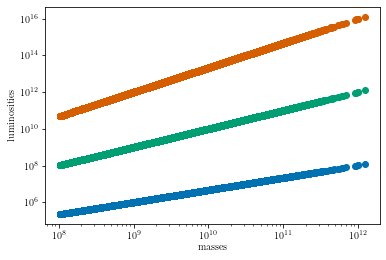

In [43]:
fig, ax = plt.subplots()

ax.scatter(masses, luminosities_L)
ax.scatter(masses, luminosities_M)
ax.scatter(masses, luminosities_H)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('masses')
ax.set_ylabel('luminosities')

In [45]:
np.mean(intensities_L), np.mean(intensities_M), np.mean(intensities_H)

(<Quantity 0.35125622 Jy / sr>,
 <Quantity 389.09235634 Jy / sr>,
 <Quantity 631680.50596367 Jy / sr>)

#### Checking unit conversion

Intensities are often given in units of Janskies.  Let's make sure that we are converting correctly from one to the other, and they are comparable to the Lidz and Beane result (https://arxiv.org/pdf/1806.02796.pdf)

In [47]:
print('Lidz: ', 3.1e2,
      ' My code: ', utils.specific_intensity(9.41))
print('Lidz: ', 7.1e2,
      ' My code: ', utils.specific_intensity(7.37))
print('Lidz: ', 1.1e3,
      'My code: ', utils.specific_intensity(6.43))

Lidz:  310.0  My code:  296.85416094619967 Jy / sr
Lidz:  710.0  My code:  675.7372227764706 Jy / sr
Lidz:  1100.0 My code:  1065.0564106095567 Jy / sr


In [50]:
def gen_spectra(fields): 

    lines_indices = np.zeros((int(comb(runs, 2) + runs), 2))
    pspecs = np.zeros((int(comb(runs, 2) + runs), n_bins))
    pspecs_dim = np.zeros((int(comb(runs, 2) + runs), n_bins))
    
    counter = 0
    for i in range(runs):
        for j in range(i, runs):
            print('Calculating correlation for Lines', i, ' and ', j)
            print('with power indices')
            k, pspec, pspec_dim = analysis.pspec(r_vec,
                            [fields[i], fields[j]],
                            n_bins=n_bins, bin_scale='log')

            pspecs[counter] = pspec
            pspecs_dim[counter] = pspec_dim

            lines_indices[counter,0] = i 
            lines_indices[counter,1] = j

            counter += 1
            
    return k, pspecs, pspecs_dim

In [51]:
indices = utils.lines_indices()
indices

array([[0., 0.],
       [0., 1.],
       [0., 2.],
       [1., 1.],
       [1., 2.],
       [2., 2.]])

In [ ]:
# shot_0 = 80**3 * a_0 * I_0.mean()**2 / len(masses) 
# shot_1 = 80**3 * a_1 * I_1.mean()**2 / len(masses) 
# shot_2 = 80**3 * a_2 * I_2.mean()**2 / len(masses)

In [54]:
I_fields = np.zeros((runs, 512, 512, 512))
scalings = [1, 10**5, 60]

for i, power in enumerate(power_indices):
    print('power =', power)
    intensities = utils.specific_intensity(z,
                            L=scalings[i] * utils.mass2luminosity(masses, power=power, mass_0=1.0))

    print('mean intensity = ', intensities.mean())
    print(' ')
    # lumens += np.random.lognormal(mean=0.0, sigma=2.0, size=None)
    I_voxels, I_edges = np.histogramdd(coords, bins=512, weights=intensities)
    I_fields[i] = I_voxels

power = 1.3
mean intensity =  295616.1224830153 Jy / sr
 
power = 0.6666666666666666
mean intensity =  35125.62161645958 Jy / sr
 
power = 1.0
mean intensity =  23345.54138022396 Jy / sr
 


power= 1.3
mean=  525384632064.2446 solLum
power= 0.6666666666666666
mean=  197411872.38227138 solLum
power= 1.0
mean=  5356456389.954758 solLum


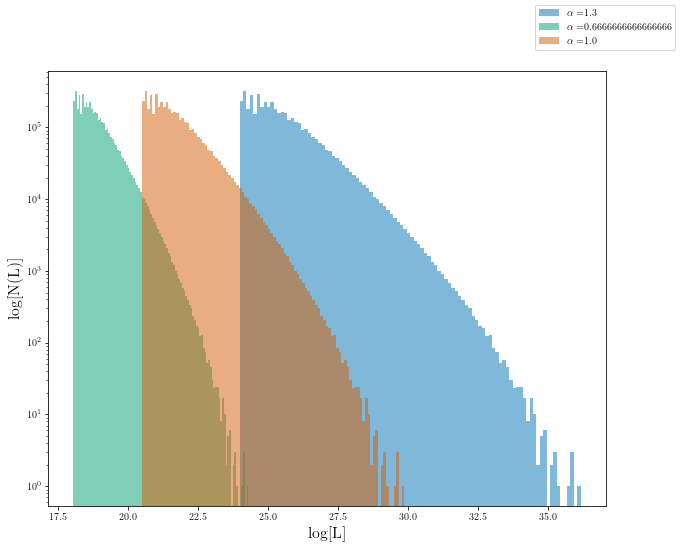

In [55]:
fig, ax = plt.subplots(figsize=(10,8))

for i, power in enumerate(power_indices):
    print('power=', power)
    lumens = np.sqrt(scalings[i]) * utils.mass2luminosity(masses, power=power, mass_0=1.0)
    print('mean= ', lumens.mean())
    n, bins, _ = ax.hist(np.log(lumens.value), 100, alpha = 0.5, lw=3, log=True, label=r'$\alpha=$' + str(power))
    
ax.set_xlabel(r'log[L]', fontsize=16)
ax.set_ylabel(r'log[N(L)]', fontsize=16)

fig.legend()

    
    # print('shot noise for index, alpha=', power, ': is ', integral)
    

In [58]:
I_fields[2][1][-1][2]

4232.771879544104

In [59]:
I_fields[0] = t21_field

In [60]:
bias_CII = 3

#Lidz_pspec = (utils.specific_intensity(6.0) * 3)**2 * density_pspec_lin
Lidz_pspec_log = (utils.specific_intensity(6.0) * bias_CII)**2 * density_pspec_log
Lidz_pspec_dim = (utils.specific_intensity(6.0) * bias_CII)**2 * density_pspec_dimless_log

In [61]:
def set_I_mean(Lidz_pspec_log, P_x):
    return np.sqrt(Lidz_pspec_log / P_x)

The shot noise can be roughly approximated as such. Since the shot noise is due to number of sources, we expect the shot noise to increase with decreasing number density.  If we assume it scales inversely, then this is roughly,
$$
\sigma_{\text{shot}} \propto \frac{1}{\bar{n}} = \frac{V}{N}
$$
The dimensions of the power spectrum are,
$$
[\text{field}^2][V]
$$
To be consistent dimensionally, we multiply by the mean of the field (in our case, $T$),
$$
\sigma_{\text{shot}} \sim \frac{{<\tilde{T}^2>} V}{N}
$$

In [ ]:
shot_0, shot_1, shot_2

In [62]:
spectra_fields = analysis.gen_spectra(r_vec, I_fields)

Calculating correlation for Lines 0  and  0
voxel size is:  0.15655577299412915  Mpc
voxel volume is:  [0.00383714]  Mpc^3
survey volume is:  [515011.75700904]  Mpc^3
bin scale is: log
min resolution: k= 0.07853981633974483
Calculating correlation for Lines 0  and  1
voxel size is:  0.15655577299412915  Mpc
voxel volume is:  [0.00383714]  Mpc^3
survey volume is:  [515011.75700904]  Mpc^3
bin scale is: log
min resolution: k= 0.07853981633974483
Calculating correlation for Lines 0  and  2
voxel size is:  0.15655577299412915  Mpc
voxel volume is:  [0.00383714]  Mpc^3
survey volume is:  [515011.75700904]  Mpc^3
bin scale is: log
min resolution: k= 0.07853981633974483
Calculating correlation for Lines 1  and  1
voxel size is:  0.15655577299412915  Mpc
voxel volume is:  [0.00383714]  Mpc^3
survey volume is:  [515011.75700904]  Mpc^3
bin scale is: log
min resolution: k= 0.07853981633974483
Calculating correlation for Lines 1  and  2
voxel size is:  0.15655577299412915  Mpc
voxel volume is:  [

### Generate spectra

Now that we have our 21cm brightness temperature field, we can go ahead and calculate our spectra.

In [68]:
indices

array([[0., 0.],
       [0., 1.],
       [0., 2.],
       [1., 1.],
       [1., 2.],
       [2., 2.]])

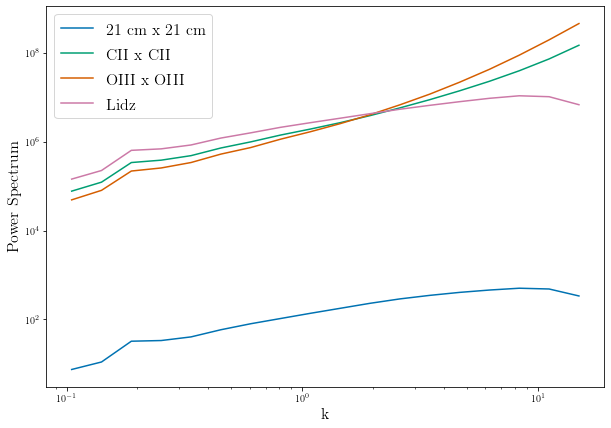

In [72]:
fig, ax = plt.subplots()

fig.set_figheight(7)
fig.set_figwidth(10)

line_labels = [r'21 cm', r'CII', r'OIII']

#ax.axvline(k_log[9], color='black', ls='--', alpha=.2)

#plt.loglog(k_log, Lidz_pspec_log, label='Lidz log')

plt.loglog(k[1:-1], spectra_fields[2][0][1:-1], marker='None',
        label=r'{} x {} '.format(line_labels[int(indices[0][0])],
                                                       line_labels[int(indices[0][1])]))

plt.loglog(k[1:-1], spectra_fields[2][3][1:-1], marker='None',
        label=r'{} x {} '.format(line_labels[int(indices[3][0])],
                                                       line_labels[int(indices[3][1])]))

plt.loglog(k[1:-1], spectra_fields[2][5][1:-1], marker='None',
        label=r'{} x {} '.format(line_labels[int(indices[5][0])],
                                                       line_labels[int(indices[5][1])]))

plt.loglog(k[1:-1], Lidz_pspec_dim[1:-1], label='Lidz')

plt.xlabel('k',fontsize=16)
plt.ylabel('Power Spectrum', fontsize=16)

plt.legend(fontsize=16)

Let's plot the power spectrum, $P(k)$,

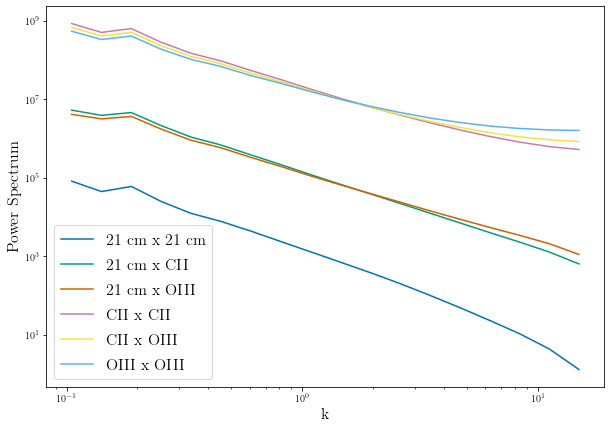

In [73]:
fig, ax = plt.subplots()

fig.set_figheight(7)
fig.set_figwidth(10)

line_labels = [r'21 cm', r'CII', r'OIII']

#ax.axvline(k_log[9], color='black', ls='--', alpha=.2)

#plt.loglog(k_log, Lidz_pspec_log, label='Lidz log')

for i in range(len(spectra_fields[1])):
    plt.loglog(k[1:-1], spectra_fields[1][i][1:-1], marker='None',
        label=r'{} x {} '.format(line_labels[int(indices[i][0])],
                                                       line_labels[int(indices[i][1])]))

plt.xlabel('k',fontsize=16)
plt.ylabel('Power Spectrum', fontsize=16)

plt.legend(fontsize=16)

and the dimensionless power spectrum, $\Delta(k)$,

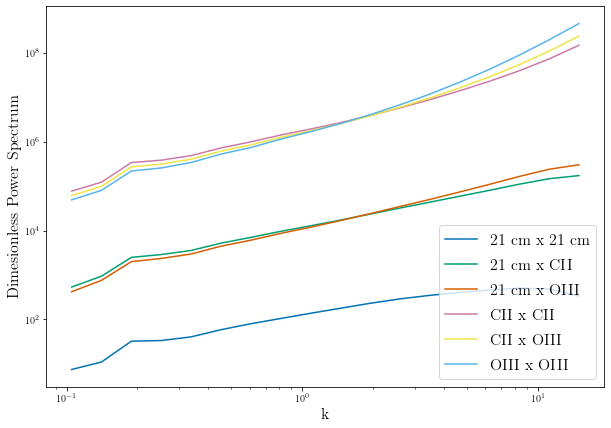

In [74]:
fig, ax = plt.subplots()

fig.set_figheight(7)
fig.set_figwidth(10)

line_labels = [r'21 cm', r'CII', r'OIII']

#ax.axvline(k_log[9], color='black', ls='--', alpha=.2)

#plt.loglog(k_log, Lidz_pspec_log, label='Lidz log')

for i in range(len(spectra_fields[1])):
    plt.loglog(k[1:-1], spectra_fields[2][i][1:-1], marker='None',
        label=r'{} x {} '.format(line_labels[int(indices[i][0])],
                                                       line_labels[int(indices[i][1])]))

plt.xlabel('k',fontsize=16)
plt.ylabel('Dimesionless Power Spectrum', fontsize=16)


plt.legend(fontsize=16)

### Comparing amplitudes with Lidz et al.

We want to make sure that our spectra are reasonable.

In [75]:
indices

array([[0., 0.],
       [0., 1.],
       [0., 2.],
       [1., 1.],
       [1., 2.],
       [2., 2.]])

In [76]:
(Lidz_pspec_log * k**3) / Lidz_pspec_dim

/Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


<Quantity [        nan, 12.83475844, 11.35200712, 12.41002069, 11.84021113,
           11.7151655 , 12.11568327, 12.09505195, 11.98973368, 12.02902586,
           12.12630855, 12.15838041, 12.17525221, 12.18578794, 12.18591735,
           12.18912699, 12.26907768, 12.51544206, 12.90439892,         nan]>

In [77]:
np.pi**2

9.869604401089358

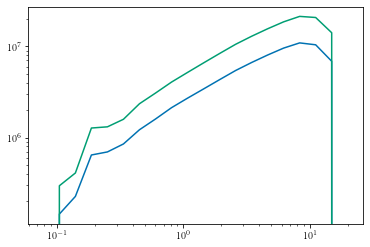

In [78]:
plt.loglog(k, Lidz_pspec_dim)
plt.loglog(k, Lidz_pspec_log * k**3 / (2 * np.pi))

#### Autocorrelations

In [306]:
P_21cm_21cm = spectra_fields[1][0] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2)
P_dim_21cm_21cm = spectra_fields[2][0] * u.Jy**2 * u.steradian**(-2)

P_CII_CII = spectra_fields[1][3] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2)
P_dim_CII_CII = spectra_fields[2][3] * u.Jy**2 * u.steradian**(-2)

P_OIII_OIII = spectra_fields[1][5] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2)
P_dim_OIII_OIII = spectra_fields[2][5] * u.Jy**2 * u.steradian**(-2)

In [165]:
indices

array([[0., 0.],
       [0., 1.],
       [0., 2.],
       [1., 1.],
       [1., 2.],
       [2., 2.]])

In [297]:
P_N

<Quantity 7.12075491e-12 MJy2 Mpc3 / (s2 sr2)>

#### Crosscorrelations 

In [305]:
P_21cm_CII = spectra_fields[1][1] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2)
P_dim_21cm_CII = spectra_fields[2][1] * u.Jy**2 * u.steradian**(-2)

P_21cm_OIII = spectra_fields[1][2] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2)
P_dim_21cm_OIII = spectra_fields[2][2] * u.Jy**2 * u.steradian**(-2)

P_CII_OIII = spectra_fields[1][4] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2)
P_dim_CII_OIII = spectra_fields[2][4] * u.Jy**2 * u.steradian**(-2)

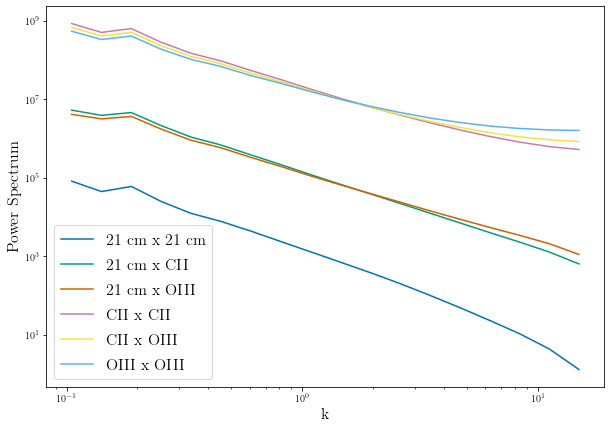

In [81]:
fig, ax = plt.subplots()

fig.set_figheight(7)
fig.set_figwidth(10)

line_labels = [r'21 cm', r'CII', r'OIII']

#ax.axvline(k_log[9], color='black', ls='--', alpha=.2)

#plt.loglog(k_log, Lidz_pspec_log, label='Lidz log')

for i in range(len(spectra_fields[1])):
    plt.loglog(k[1:-1], spectra_fields[1][i][1:-1], marker='None',
        label=r'{} x {} '.format(line_labels[int(indices[i][0])],
                                                       line_labels[int(indices[i][1])]))

plt.xlabel('k',fontsize=16)
plt.ylabel('Power Spectrum', fontsize=16)

plt.legend(fontsize=16)

In [ ]:
utils.calc_N_modes(k[2], k[2] - k[1], )

# Surveys

test with different values of the power index, alpha

In [391]:
def error_bars(P_x, P_line1, P_line2, P_N, W_k, N_modes):
    sigma = (1 / np.sqrt(N_modes)) * np.sqrt(P_x**2 
                                            + P_line1 * (P_line2 + P_N / W_k**2))
    return sigma

def var_x(P_i, W_i, P_j, W_j, P_Ni, P_Nj, P_x, N_modes):
    W_x = np.sqrt(W_i * W_j)
    
    return ((P_i * W_i + P_Ni) * (P_j * W_j + P_Nj) + P_x**2 * W_x**2) / (2 * N_modes)
    

def calc_N_modes(k, V_surv, align='center'):
    
    k_vals = np.zeros(len(k) - 1)    
    delta_k = k[1:] - k[:-1] 

    if align is 'left':
        k_vals = k[:-1]

    if align is 'center':
        k_vals = (k[1:] + k[:-1]) / 2 

    if align is 'right':
        k_vals = k[1:]

    N_modes = k_vals**2 * delta_k * V_surv.to_value() / (4 * np.pi**2)

    return N_modes

def calc_P_N(sigma_pix, V_vox, t_pix):
    P_N = sigma_pix**2 * V_vox / t_pix
    
    return P_N

def calc_t_pix(N_det, t_obs, Omega_surv, sigma_beam):
    Omega_pix = 2 * np.pi * sigma_beam**2
    
    t_pix = N_det * t_obs / (Omega_surv / Omega_pix) 
    
    return t_pix.to(u.s, equivalencies=u.dimensionless_angles())

def calc_L_perp(z, Omega):
    # This assumes a square survey   
    return np.sqrt(Planck15.comoving_distance(z)**2 \
            * Omega).to(u.Mpc, equivalencies=u.dimensionless_angles()) * Planck15.h

def calc_L_para(z, nu_rest, delta_nu):
    return ((const.c / Planck15.H(z)) * delta_nu * (1 + z)**2 / \
            nu_rest).to(u.Mpc) * Planck15.h

def calc_V(z, width_perp, width_para, nu_rest):
    L_perp = calc_L_perp(z, width_perp)
    L_para = calc_L_para(z, nu_rest, width_para)
    
    return L_perp**2 * L_para

def calc_V_vox(z, sigma_beam, delta_nu, nu_rest):
    Omega_beam = sigma_beam**2
    V_vox = calc_V(z, Omega_beam, delta_nu, nu_rest)
    
    return V_vox

def calc_V_survey(z, Omega_surv, B_nu, nu_rest):
    V_survey = calc_V(z, Omega_surv, B_nu, nu_rest)
    
    return V_survey

def calc_V_surv_generic(z,lambda_rest, Omega_surv, B_nu):
    A_s = Omega_surv  
    B_nu = B_nu
    r = Planck15.comoving_distance(z)
    y = (lambda_rest * (1 + z)**2) / Planck15.H(z)

    V = r**2 * y * A_s * B_nu * Planck15.h**3
    
    return V.to(u.Mpc**3, equivalencies=u.dimensionless_angles())

def calc_V_surv_ij(z, lambda_i, Omega_surv_j, B_nu_j):
    # units in nanometers, GHz
    A = 3.3e7 * u.Mpc**3 # just a random prefactor (Mpc / h)^3
    V_surv_ij = A * (lambda_i / (158 * u.micron)) * np.sqrt((1 + z) / 8) \
                    * (Omega_surv_j / (16 * u.degree**2)) * (B_nu_j / (20 * u.GHz))

    return V_surv_ij.decompose().to(u.Mpc**3)

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(8,9))

line_labels = [r'21 cm', r'CII', r'OIII']

#ax.axvline(k_log[9], color='black', ls='--', alpha=.2)

#plt.loglog(k_log, Lidz_pspec_log, label='Lidz log')

for i in range(len(spectra_fields[1])):
    ax[0].loglog(k[1:-1], spectra_fields[2][i][1:-1], marker='None',
        label=r'{} x {} '.format(line_labels[int(indices[i][0])],
                                                       line_labels[int(indices[i][1])]))
    
for i in range(len(spectra_fields[1])):
    ax[1].loglog(k[1:-1], spectra_fields[2][i][1:-1] * W_k[1:-1], marker='None',
        label=r'{} x {} '.format(line_labels[int(indices[i][0])],
                                                       line_labels[int(indices[i][1])]))

ax[1].set_xlabel('k',fontsize=16)
ax[0].set_ylabel(r'$\Delta^2 (k)$', fontsize=16)
ax[1].set_ylabel(r'$\Delta^2 (k) W(k)$', fontsize=16)


ax[0].legend(fontsize=16)
plt.tight_layout()

### Checking the resolution of the instrument

The maximum resolvable $k$ of the instrument is set by the size of the survey volume. This is roughly,
$$
V \approx R(z)^2\Omega \left[ \frac{c}{H(z)} \frac{B_{\nu} (1+z)^2}{\nu_{\text{rest}}} \right]
$$
Where the term $\sqrt{R(z)^2 \Omega}$ sets the minimum $k_{\perp}$ and $\left[ \frac{c}{H(z)} \frac{B_{\nu} (1+z)^2}{\nu_{\text{rest}}} \right]$ sets the minimum $k_{\parallel}$.

Then the maximum resolution is,
$$k_{\text{max}} = \sqrt{2 k_{\perp, \text{max}}^2 + k_{\parallel, \text{max}}^2} \\
= \sqrt{\left( \frac{4 \pi}{\sqrt{R(z)^2 \Omega}} \right)^2 + \left(\frac{2 \pi}{\left[ \frac{c}{H(z)} \frac{B_{\nu} (1+z)^2}{\nu_{\text{rest}}} \right]}\right)^2 }
$$

### Survey specifications

We now want to construct three surveys that have the same coverage in 2D k-space, such that we can perform cross correlations. We want three different lines, corresponding to 21 cm, CII, and OIII.

In [84]:
def calc_L_perp(z, Omega):
    # This assumes a square survey   
    return np.sqrt(Planck15.comoving_distance(z)**2 \
            * Omega).to(u.Mpc, equivalencies=u.dimensionless_angles()) * Planck15.h

def calc_L_para(z, nu_rest, delta_nu):
    return ((const.c / Planck15.H(z)) * delta_nu * (1 + z)**2 / \
            nu_rest).to(u.Mpc) * Planck15.h

def set_L_perp(k_perp_min, z):
    R_z = Planck15.comoving_distance(z) * Planck15.h
    Omega_surv = ((2 * np.pi)**2 / (k_perp_min * R_z)**2) * u.radian**2

    return Omega_surv.to(u.degree**2)

def set_L_para(k_para_min, z, nu_rest):
    B_nu = (2 * np.pi * Planck15.H(z) * nu_rest) / \
            (const.c * k_para_min * (1 + z)**2) * Planck15.h
    
    return B_nu
    

In [85]:
k_units = k_log * u.Mpc**(-1)

# max and min k values are partially determined by the simulation box size
k_perp_min_box = (2 * np.pi) / (box_size * u.Mpc)
k_para_min_box = (2 * np.pi) / (box_size * u.Mpc)

k_perp_max_box = (2 * np.pi) / ((box_size * u.Mpc) / 512)
k_para_max_box = (2 * np.pi) / ((box_size * u.Mpc) / 512)

In [86]:
nu_21cm = 1420.4 * u.MHz
nu_21cm_obs = utils.calc_nu_obs(nu_21cm, z)

lambda_21cm = utils.nu_to_wavelength(nu_21cm)

In [88]:
nu_CII = 1.9 * u.THz
nu_CII_obs = utils.calc_nu_obs(nu_CII, z)

lambda_CII = utils.nu_to_wavelength(nu_CII).to(u.micron) # micrometers

In [89]:
lambda_OIII = 88 * u.micron ## micrometers

nu_OIII = utils.wavelength_to_nu(lambda_OIII)
nu_OIII_obs = utils.calc_nu_obs(nu_OIII, z)

In [90]:
set_L_perp(k_perp_min_box, z)

<Quantity 0.64349982 deg2>

In [94]:
sigma_beam = 1.22 * lambda_CII / (3 * u.m)

Omega_surv_21cm = set_L_perp(k_perp_min_box, z)
Omega_surv_CII = set_L_perp(k_perp_min_box, z)
Omega_surv_OIII = set_L_perp(k_perp_min_box, z)

B_21cm = set_L_para(k_para_min_box, z, nu_21cm)
B_CII = set_L_para(k_para_min_box, z, nu_CII)
B_OIII = set_L_para(k_para_min_box, z, nu_OIII)

In [105]:
sigma_perp_21cm = utils.calc_sigma_perp(z, sigma_beam)
sigma_perp_CII = utils.calc_sigma_perp(z, sigma_beam)
sigma_perp_OIII = utils.calc_sigma_perp(z, sigma_beam)

In [139]:
delta_nu_CII = 10 * u.MHz
sigma_para_CII = utils.calc_sigma_para(z, nu_CII_obs, delta_nu_CII)

delta_nu_21cm = utils.set_sigma_para(sigma_para_CII, z, nu_21cm_obs)
sigma_para_21cm = utils.calc_sigma_para(z, nu_21cm_obs, delta_nu_21cm)

delta_nu_OIII = utils.set_sigma_para(sigma_para_CII, z, nu_OIII_obs)
sigma_para_OIII = utils.calc_sigma_para(z, nu_OIII_obs, delta_nu_OIII)

In [140]:
print(delta_nu_21cm.to(u.kHz))
print(delta_nu_CII.to(u.MHz))
print(delta_nu_OIII.to(u.MHz))

7.475789473684212 kHz
10.0 MHz
17.930170933014352 MHz


In [141]:
L_perp_21cm = calc_L_perp(z, Omega_surv_21cm)
L_para_21cm = calc_L_para(z, nu_21cm, B_21cm)

L_perp_CII = calc_L_perp(z, Omega_surv_CII)
L_para_CII = calc_L_para(z, nu_CII, B_CII)

L_perp_OIII = calc_L_perp(z, Omega_surv_OIII)
L_para_OIII = calc_L_para(z, nu_OIII, B_OIII)

In [142]:
k_perp_min_21cm = (2 * np.pi / L_perp_21cm)
k_perp_min_CII = (2 * np.pi / L_perp_CII)
k_perp_min_OIII = (2 * np.pi / L_perp_OIII)

k_para_min_21cm = (2 * np.pi / L_para_21cm)
k_para_min_CII = (2 * np.pi / L_para_CII)
k_para_min_OIII = (2 * np.pi / L_para_OIII)

k_perp_max_21cm = 1 / sigma_perp_21cm
k_perp_max_CII = 1 / sigma_perp_CII
k_perp_max_OIII = 1 / sigma_perp_OIII

k_para_max_21cm = 1 / sigma_para_21cm
k_para_max_CII = 1 / sigma_para_CII
k_para_max_OIII = 1 / sigma_para_OIII

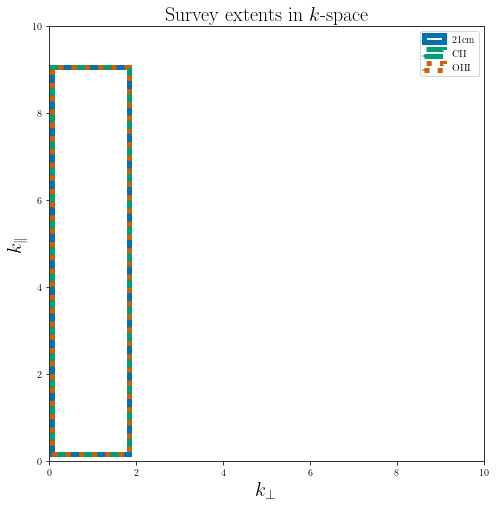

In [148]:
import matplotlib.patches as patches

fig, ax = plt.subplots(1,1, figsize=(8, 8))

# Create a Rectangle patch
rect_21cm = patches.Rectangle((k_perp_min_21cm.value, k_para_min_21cm.value),
                                (k_perp_max_21cm - k_perp_min_21cm).value,
                                (k_para_max_21cm - k_para_min_21cm).value,
                              linewidth=5, edgecolor=colors[0], facecolor='none')

rect_CII = patches.Rectangle((k_perp_min_CII.value, k_para_min_CII.value),
                                (k_perp_max_CII - k_perp_min_CII).value,
                                (k_para_max_CII - k_para_min_CII).value,
                              linewidth=5, ls='--', edgecolor=colors[1], facecolor='none')

rect_OIII = patches.Rectangle((k_perp_min_OIII.value, k_para_min_OIII.value),
                                (k_perp_max_OIII - k_perp_min_OIII).value,
                                (k_para_max_OIII - k_para_min_OIII).value,
                              linewidth=5, ls=':', edgecolor=colors[2], facecolor='none')


# Add the patch to the Axes
ax.add_patch(rect_21cm)
ax.add_patch(rect_CII)
ax.add_patch(rect_OIII)

setup = ax.set(xlim=(0, 10), ylim=(0, 10), aspect=1)
x_l = ax.set_xlabel(r'$k_{\perp}$', fontsize=20)
y_l = ax.set_ylabel(r'$k_{\parallel}$', fontsize=20)

title = ax.set_title('Survey extents in $k$-space', fontsize=20)
leg = ax.legend(['21cm', 'CII', 'OIII'])

### Weighting function for smoothing power spectrum

Now we want to consider the fact that an instrument does have equal sensitivity at all values of $k$.

In [144]:
W_k_21cm = utils.calc_W_k(k_units, sigma_perp_21cm, sigma_para_21cm)
W_k_21cm

array([9.98771098e-01, 9.97799159e-01, 9.96060299e-01, 9.92953302e-01,
       9.87414286e-01, 9.77579544e-01, 9.60243786e-01, 9.30079168e-01,
       8.78788404e-01, 7.95064393e-01, 6.67835687e-01, 4.96860913e-01,
       3.09227174e-01, 1.57144613e-01, 7.04809542e-02, 3.00372045e-02,
       1.12229597e-02, 3.15478088e-03, 5.23488553e-04, 3.35219592e-05])

In [150]:
W_k_CII = utils.calc_W_k(k_units, sigma_perp_CII, sigma_para_CII)
W_k_CII

array([9.98771098e-01, 9.97799159e-01, 9.96060299e-01, 9.92953302e-01,
       9.87414286e-01, 9.77579544e-01, 9.60243786e-01, 9.30079168e-01,
       8.78788404e-01, 7.95064393e-01, 6.67835687e-01, 4.96860913e-01,
       3.09227174e-01, 1.57144613e-01, 7.04809542e-02, 3.00372045e-02,
       1.12229597e-02, 3.15478088e-03, 5.23488553e-04, 3.35219592e-05])

In [151]:
W_k_OIII = utils.calc_W_k(k_units, sigma_perp_OIII, sigma_para_OIII)
W_k_OIII

array([9.98771098e-01, 9.97799159e-01, 9.96060299e-01, 9.92953302e-01,
       9.87414286e-01, 9.77579544e-01, 9.60243786e-01, 9.30079168e-01,
       8.78788404e-01, 7.95064393e-01, 6.67835687e-01, 4.96860913e-01,
       3.09227174e-01, 1.57144613e-01, 7.04809542e-02, 3.00372045e-02,
       1.12229597e-02, 3.15478088e-03, 5.23488553e-04, 3.35219592e-05])

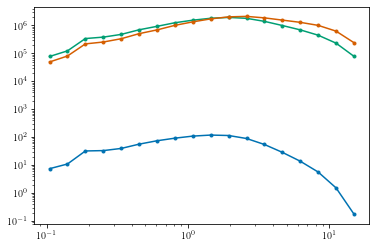

In [154]:
#plt.plot(k, W_k_CCATp, color='red')
plt.loglog(k[1:-1], P_dim_21cm_21cm[1:-1] * W_k_21cm[1:-1],
            color=colors[0], marker='.')

plt.loglog(k[1:-1], P_dim_CII_CII[1:-1] * W_k_CII[1:-1],
            color=colors[1], marker='.')

plt.loglog(k[1:-1], P_dim_OIII_OIII[1:-1] * W_k_OIII[1:-1],
            color=colors[2], marker='.')


#plt.axvline(1 / sigma_para_CCATp.to_value(), color='red', ls='--', alpha=.2)
# plt.axvline(1 / sigma_perp_FYST.to_value(), color='b')

### Errors

Now we need to make sure our we have realistic estimated errors on our measurements.

In [393]:
V_survey_21cm = calc_V_survey(z, Omega_surv_21cm, B_21cm, nu_21cm)
V_survey_CII = calc_V_survey(z, Omega_surv_CII, B_CII, nu_CII)
V_survey_OIII = calc_V_survey(z, Omega_surv_OIII, B_21cm, nu_OIII)

V_vox_21cm = calc_V_vox(z, sigma_beam, delta_nu_21cm, nu_21cm)
V_vox_CII = calc_V_vox(z, sigma_beam, delta_nu_CII, nu_CII)
V_vox_OIII = calc_V_vox(z, sigma_beam, delta_nu_OIII, nu_OIII)

#### N modes check

In [162]:
N_modes = calc_N_modes(k, V_survey_21cm, align='left')
N_modes

array([9.76323026e-01, 2.34192812e+00, 5.61763592e+00, 1.34751503e+01,
       3.23231477e+01, 7.75342651e+01, 1.85983195e+02, 4.46122094e+02,
       1.07012315e+03, 2.56692860e+03, 6.15734966e+03, 1.47697738e+04,
       3.54285905e+04, 8.49833609e+04, 2.03851509e+05, 4.88983224e+05,
       1.17293511e+06, 2.81354598e+06, 6.74891635e+06])

In [483]:
k_vals = np.zeros(len(k) - 1)    
delta_k = k[1:] - k[:-1] 

k_vals = k[:-1]

N_modes = k_vals**2 * delta_k * V_survey_21cm.to_value() / (4 * np.pi**2)


In [506]:
np.log10(k_log)[3] - np.log10(k_log)[2]

0.1266600094965239

In [514]:
x1 = np.linspace(np.log10(1), np.log10(1000), num=4)
x1

array([0., 1., 2., 3.])

In [508]:
np.logspace(np.log10(1), np.log10(1000), num=4)

array([   1.,   10.,  100., 1000.])

In [517]:
x = np.geomspace(1, 1000, num=4)
x

array([   1.,   10.,  100., 1000.])

In [522]:
(x[1:] - x[:-1]) / x[1:], (x[1:] - x[:-1]) / x[:-1]

(array([0.9, 0.9, 0.9]), array([9., 9., 9.]))

In [516]:
for i in range(4):
    print(10**i)

1
10
100
1000


In [491]:
np.log10(np.logspace(0, 5))

array([0.        , 0.10204082, 0.20408163, 0.30612245, 0.40816327,
       0.51020408, 0.6122449 , 0.71428571, 0.81632653, 0.91836735,
       1.02040816, 1.12244898, 1.2244898 , 1.32653061, 1.42857143,
       1.53061224, 1.63265306, 1.73469388, 1.83673469, 1.93877551,
       2.04081633, 2.14285714, 2.24489796, 2.34693878, 2.44897959,
       2.55102041, 2.65306122, 2.75510204, 2.85714286, 2.95918367,
       3.06122449, 3.16326531, 3.26530612, 3.36734694, 3.46938776,
       3.57142857, 3.67346939, 3.7755102 , 3.87755102, 3.97959184,
       4.08163265, 4.18367347, 4.28571429, 4.3877551 , 4.48979592,
       4.59183673, 4.69387755, 4.79591837, 4.89795918, 5.        ])

In [489]:
k_vals

array([ 0.07853982,  0.10513562,  0.14073752,  0.18839523,  0.25219119,
        0.33759028,  0.45190791,  0.60493672,  0.80978543,  1.08400171,
        1.45107539,  1.94245061,  2.60021941,  3.48072734,  4.6594002 ,
        6.23720508,  8.34929937, 11.17660861, 14.96132484])

In [487]:
k_vals[1] - k_vals[0]

0.026595806254997606

In [488]:
delta_k

array([0.02659581, 0.0356019 , 0.04765771, 0.06379596, 0.08539908,
       0.11431763, 0.15302882, 0.20484871, 0.27421628, 0.36707368,
       0.49137522, 0.65776879, 0.88050794, 1.17867286, 1.57780487,
       2.11209429, 2.82730924, 3.78471622, 5.06632833])

In [485]:
delta_k / k_vals

array([0.33862832, 0.33862832, 0.33862832, 0.33862832, 0.33862832,
       0.33862832, 0.33862832, 0.33862832, 0.33862832, 0.33862832,
       0.33862832, 0.33862832, 0.33862832, 0.33862832, 0.33862832,
       0.33862832, 0.33862832, 0.33862832, 0.33862832])

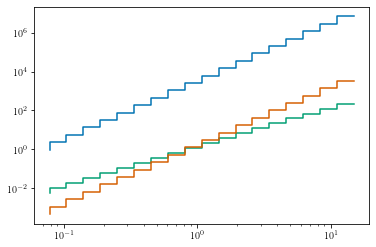

In [480]:
plt.loglog(k[:-1], N_modes, drawstyle='steps')
plt.loglog(k[:-1], k[:-1]**2, drawstyle='steps')
plt.loglog(k[:-1], k[:-1]**3, drawstyle='steps')

In [168]:
V_survey_21cm / V_vox_21cm

<Quantity 23365356.54497159>

In [394]:
V_survey_CII / V_vox_CII 

<Quantity 23365356.54497159>

In [474]:
# Need to update with HERA
t_pix_21cm = calc_t_pix(specs_CCATp['N_det'], specs_CCATp['t_obs'],
                                                   Omega_surv_CII, sigma_beam)

t_pix_CII = calc_t_pix(specs_StageII['N_det'], specs_StageII['t_obs'],
                                                   Omega_surv_CII, sigma_beam)
t_pix_OIII = calc_t_pix(specs_EXCLAIM['N_det'], specs_EXCLAIM['t_obs'],
                                                   Omega_surv_OIII, sigma_beam)

P_N_21cm = calc_P_N(specs_StageII['sigma_pix'], V_vox_21cm, t_pix_21cm)
P_N_CII = calc_P_N(specs_StageII['sigma_pix'], V_vox_CII, t_pix_CII)
P_N_OIII = calc_P_N(specs_EXCLAIM['sigma_pix'], V_vox_OIII, t_pix_OIII)

N_modes_StageII = calc_N_modes(k, V_survey_21cm, align='left')

P_CV = P_21cm_CII[:-1] / np.sqrt(N_modes)
P_shot = np.sqrt(P_21cm_21cm[:-1] * P_CII_CII[:-1]) / np.sqrt(N_modes)
P_noise = (P_N_CII * P_CII_CII[:-1]) / (W_k_21cm[:-1]**2 * np.sqrt(N_modes))

sigma_21cm_CII = error_bars(P_21cm_CII[:-1], P_21cm_21cm[:-1], P_CII_CII[:-1],
                                                P_N, W_k_21cm[:-1], N_modes) 

var_21cm_CII = var_x(P_21cm_21cm[:-1], W_k_21cm[:-1], P_CII_CII[:-1], W_k_CII[:-1], P_N_21cm,
                     P_N_CII, P_21cm_CII[:-1], N_modes)

var_21cm_OIII = var_x(P_21cm_21cm[:-1], W_k_21cm[:-1], P_OIII_OIII[:-1], W_k_OIII[:-1],
                      P_N_21cm, P_N_OIII, P_21cm_OIII[:-1], N_modes)

var_CII_OIII = var_x(P_CII_CII[:-1], W_k_CII[:-1], P_OIII_OIII[:-1], W_k_OIII[:-1],
                      P_N_CII, P_N_OIII, P_CII_OIII[:-1], N_modes)

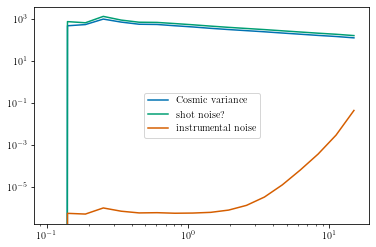

In [475]:
plt.loglog(k[1:-1], k[1:-1]**3 * P_CV[:-1] / (2 * np.pi**2), label='Cosmic variance')
plt.loglog(k[1:-1], k[1:-1]**3 * P_shot[:-1] / (2 * np.pi**2), label='shot noise?')
plt.loglog(k[1:-1], k[1:-1]**3 * P_noise[:-1] / (2 * np.pi**2), label='instrumental noise')

plt.legend()

In [473]:
N_modes

array([9.76323026e-01, 2.34192812e+00, 5.61763592e+00, 1.34751503e+01,
       3.23231477e+01, 7.75342651e+01, 1.85983195e+02, 4.46122094e+02,
       1.07012315e+03, 2.56692860e+03, 6.15734966e+03, 1.47697738e+04,
       3.54285905e+04, 8.49833609e+04, 2.03851509e+05, 4.88983224e+05,
       1.17293511e+06, 2.81354598e+06, 6.74891635e+06])

(100.0, 10000.0)

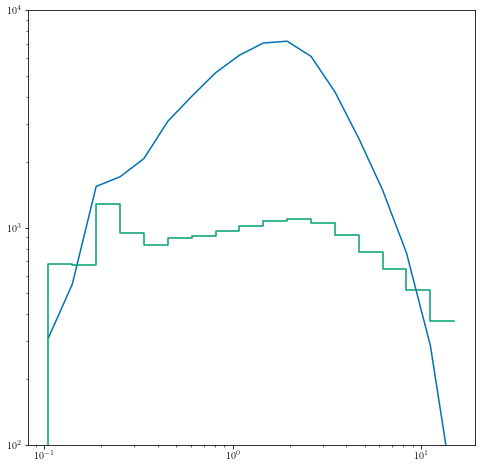

In [530]:
plt.figure(figsize=(8,8))
plt.loglog(k[1:-1], (k[1:-1]**3 * P_21cm_CII[1:-1] * W_k_CII[1:-1]).value / (2 * np.pi**2))
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_21cm_CII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps')

plt.ylim(1e2, 1e4)

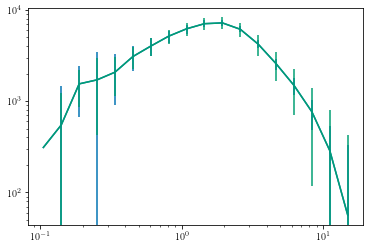

In [470]:
plt.errorbar(k[1:-1], k[1:-1]**3 * P_21cm_CII.value[1:-1] * W_k_21cm[1:-1] / (2 * np.pi**2),
                                         yerr=k[1:-1]**3 * sigma_21cm_CII.value[:-1] / (2 * np.pi**2))

plt.errorbar(k[1:-1], k[1:-1]**3 * P_21cm_CII.value[1:-1] * W_k_21cm[1:-1] / (2 * np.pi**2),
                                         yerr=k[1:-1]**3 * np.sqrt(var_21cm_CII[:-1]).value / (2 * np.pi**2))

plt.xscale('log')
plt.yscale('log')

(100.0, 10000.0)

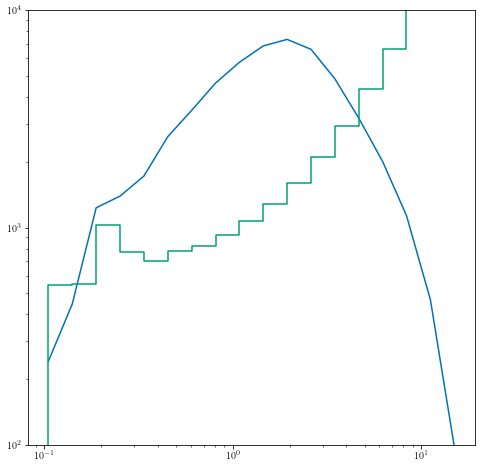

In [424]:
plt.figure(figsize=(8,8))
plt.loglog(k[1:-1], (k[1:-1]**3 * P_21cm_OIII[1:-1] * W_k_OIII[1:-1]).value / (2 * np.pi**2))
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_21cm_OIII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps')

plt.ylim(1e2, 1e4)

### Comparing noise forecasts with Padmanabhan et al.

In [249]:
# this is just checking sigma / t_pix^(1/2) with Chung et al. (2020) for CCATp

t_pix_CCATp = calc_t_pix(specs_CCATp['N_det'], specs_CCATp['t_obs'],
                                        specs_CCATp['Omega_surv'],
                                        utils.FWHM_to_sigma(specs_CCATp['theta_FWMH']))


sig_t_pix_Chung = 6.2e3 * u.Jy / u.steradian
sig_t_pix_CCATp = specs_CCATp['sigma_pix'] / np.sqrt(t_pix_CCATp)

print(sig_t_pix_Chung / sig_t_pix_CCATp.to(u.Jy / u.steradian))

1.1766898989991694


#### CCAT-p specifications

In [552]:
sigma_beam_CCATp = utils.FWHM_to_sigma(specs_CCATp['theta_FWMH'])
V_surv_CCATp = calc_V_survey(z, specs_CCATp['Omega_surv'],
                               specs_CCATp['nu_obs_max'] - specs_CCATp['nu_obs_min'],
                                nu_CII)
V_vox_CCATp = calc_V_vox(z, sigma_beam_CCATp, specs_CCATp['delta_nu'], nu_CII)
t_pix_CCATp = calc_t_pix(specs_CCATp['N_det'], specs_CCATp['t_obs'],
                                        specs_CCATp['Omega_surv'],
                                        sigma_beam_CCATp)

N_modes_CCATp = calc_N_modes(k, V_surv_CCATp, align='left')

sigma_perp_CCATp = utils.calc_sigma_perp(z, sigma_beam_CCATp)
sigma_para_CCATp = utils.calc_sigma_para(z, nu_CII_obs, specs_CCATp['delta_nu'])

P_N_CCATp = calc_P_N(specs_CCATp['sigma_pix'], V_vox_CCATp, t_pix_CCATp)
P_CV_CCATp = P_CII_CII[:-1] / np.sqrt(N_modes_CCATp)
P_shot_CCATp = P_CII_CII[:-1] / np.sqrt(N_modes_CCATp)
P_noise_CCATp = np.sqrt(P_N_CCATp * P_CII_CII[:-1]) / (W_k_CII[:-1]**2 * np.sqrt(N_modes_CCATp))

W_k_CCATp = utils.calc_W_k(k_units, sigma_perp_CCATp, sigma_para_CCATp)

var_CCATp = var_x(P_21cm_21cm[:-1], W_k_21cm[:-1], P_CII_CII[:-1], W_k_CCATp[:-1], P_N_21cm,
                     P_N_CCATp, P_21cm_CII[:-1], N_modes_CCATp)

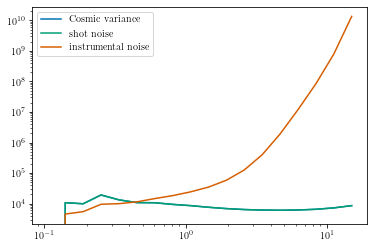

In [526]:
plt.loglog(k[1:-1], k[1:-1]**3 * P_CV_CCATp[:-1].to(u.Mpc**3 * u.Jy**2 * u.steradian**(-2)) / (2 * np.pi**2), label='Cosmic variance')
plt.loglog(k[1:-1], k[1:-1]**3 * P_shot_CCATp[:-1].to(u.Mpc**3 * u.Jy**2 * u.steradian**(-2)) / (2 * np.pi**2), label='shot noise')
plt.loglog(k[1:-1], k[1:-1]**3 *  P_noise_CCATp[:-1].to(u.Mpc**3 * u.Jy**2 * u.steradian**(-2)) / (2 * np.pi**2), label='instrumental noise')

plt.legend()

(100.0, 10000.0)

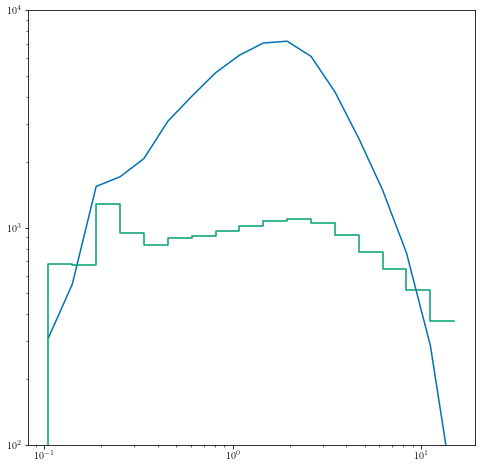

In [531]:
plt.figure(figsize=(8,8))
plt.loglog(k[1:-1], (k[1:-1]**3 * P_21cm_CII[1:-1] * W_k_CII[1:-1]).value / (2 * np.pi**2))
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_21cm_CII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps')

plt.ylim(1e2, 1e4)

#### FYST (or Stage II) specifications

In [543]:
sigma_beam_StageII = utils.FWHM_to_sigma(specs_StageII['theta_FWMH'])
V_surv_StageII = calc_V_survey(z, specs_StageII['Omega_surv'],
                               specs_StageII['nu_obs_max'] - specs_StageII['nu_obs_min'],
                                nu_CII)
V_vox_StageII = calc_V_vox(z, sigma_beam_StageII, specs_StageII['delta_nu'], nu_CII)
t_pix_StageII = calc_t_pix(specs_StageII['N_det'], specs_StageII['t_obs'],
                                        specs_StageII['Omega_surv'],
                                        sigma_beam_StageII)

N_modes_StageII = calc_N_modes(k, V_surv_StageII, align='left')

sigma_perp_StageII = utils.calc_sigma_perp(z, sigma_beam_StageII)
sigma_para_StageII = utils.calc_sigma_para(z, nu_CII_obs, specs_StageII['delta_nu'])
W_k_StageII = utils.calc_W_k(k_units, sigma_perp_StageII, sigma_para_StageII)

P_N_StageII = calc_P_N(specs_StageII['sigma_pix'], V_vox_StageII, t_pix_StageII)
P_CV_StageII = P_CII_CII[:-1] / np.sqrt(N_modes_StageII)
P_shot_StageII = P_CII_CII[:-1] / np.sqrt(N_modes_StageII)
P_noise_StageII = np.sqrt(P_N_StageII * P_CII_CII[:-1]) / (W_k_StageII[:-1]**2 * np.sqrt(N_modes_StageII))



var_StageII = var_x(P_21cm_21cm[:-1], W_k_21cm[:-1], P_CII_CII[:-1], W_k_StageII[:-1], P_N_21cm,
                     P_N_StageII, P_21cm_CII[:-1], N_modes_StageII)

In [383]:
V_surv_StageII / V_vox_StageII

<Quantity 1.9830217e+09>

In [382]:
P_shot_StageII

<Quantity [0.00000000e+00, 9.90820698e+06, 3.80498482e+06, 3.07994756e+06,
           8.88625871e+05, 3.01053230e+05, 1.24186427e+05, 4.57442872e+04,
           1.73597697e+04, 6.40083045e+03, 2.41276944e+03, 9.36315100e+02,
           3.75783697e+02, 1.54307709e+02, 6.55947050e+01, 2.88376202e+01,
           1.33480871e+01, 6.60138710e+00, 3.58780726e+00] Jy2 Mpc3 / sr2>

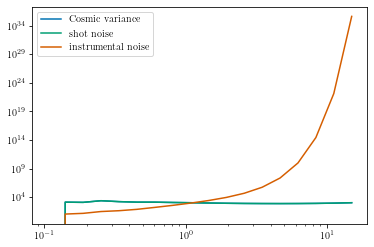

In [533]:
plt.loglog(k[1:-1], k[1:-1]**3 * P_CV_StageII[:-1].to(u.Mpc**3 * u.Jy**2 * u.steradian**(-2)) / (2 * np.pi**2), label='Cosmic variance')
plt.loglog(k[1:-1], k[1:-1]**3 * P_shot_StageII[:-1].to(u.Mpc**3 * u.Jy**2 * u.steradian**(-2)) / (2 * np.pi**2), label='shot noise')
plt.loglog(k[1:-1], k[1:-1]**3 *  P_noise_StageII[:-1].to(u.Mpc**3 * u.Jy**2 * u.steradian**(-2)) / (2 * np.pi**2), label='instrumental noise')

plt.legend()

In [ ]:
plt.figure(figsize=(8,8))
plt.loglog(k[1:-1], (k[1:-1]**3 * P_21cm_CII[1:-1] * np.sqrt(W_k_CII[1:-1] 
                                                             * W_k_21cm[1:-1])).value / (2 * np.pi**2),
                                          color=colors[0], alpha=.5, label='idealized survey')
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_21cm_CII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[0], lw=2)

(1, 10000)

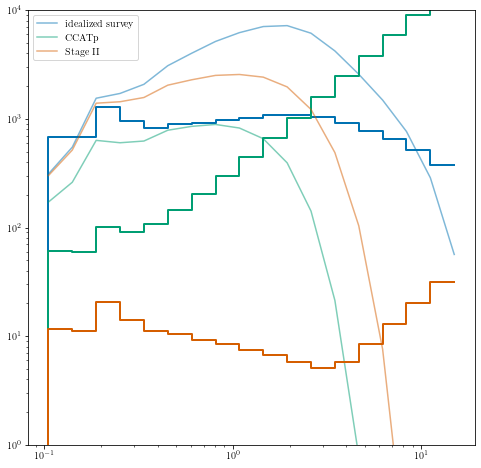

In [554]:
plt.figure(figsize=(8,8))
plt.loglog(k[1:-1], (k[1:-1]**3 * P_21cm_CII[1:-1] * np.sqrt(W_k_CII[1:-1] 
                                                             * W_k_21cm[1:-1])).value / (2 * np.pi**2),
                                          color=colors[0], alpha=.5, label='idealized survey')
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_21cm_CII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[0], lw=2)

plt.loglog(k[1:-1], (k[1:-1]**3 * P_21cm_CII[1:-1] * np.sqrt(W_k_CCATp[1:-1] 
                                                             * W_k_21cm[1:-1])).value / (2 * np.pi**2),
                                          color=colors[1], alpha=.5, label='CCATp')
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_CCATp[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[1], lw=2)

plt.loglog(k[1:-1], (k[1:-1]**3 * P_21cm_CII[1:-1] * np.sqrt(W_k_StageII[1:-1] 
                                                             * W_k_21cm[1:-1])).value / (2 * np.pi**2),
                                          color=colors[2], alpha=.5, label='Stage II')
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_StageII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[2], lw=2)

plt.legend()
plt.ylim(10**0, 10**4)

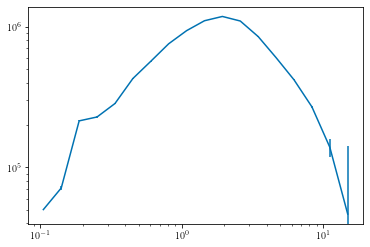

In [468]:
plt.errorbar(k[1:-1], (k[1:-1]**3 * P_CII_CII[1:-1] * W_k_21cm[1:-1]).value / (2 * np.pi**2),
                                    yerr=(k[1:-1]**3 * sigma_CII_CII[:-1]).value / (2 * np.pi**2))

plt.xscale('log')
plt.yscale('log')

#### EXCLAIM specifications

In [388]:
V_surv_EXCLAIM = calc_V_survey(z, specs_EXCLAIM['Omega_surv'],
                               specs_EXCLAIM['B_nu'],
                                nu_OIII)
V_vox_EXCLAIM = calc_V_vox(z, specs_EXCLAIM['sigma_beam'], specs_EXCLAIM['delta_nu'], nu_OIII)
t_pix_EXCLAIM = calc_t_pix(specs_EXCLAIM['N_det'], specs_EXCLAIM['t_obs'],
                                        specs_EXCLAIM['Omega_surv'],
                                        specs_EXCLAIM['sigma_beam'])
N_modes_EXCLAIM = calc_N_modes(k, V_surv_EXCLAIM, align='left')

P_N_EXCLAIM = calc_P_N(specs_EXCLAIM['sigma_pix'], V_vox_EXCLAIM, t_pix_EXCLAIM)
P_CV_EXCLAIM = P_OIII_OIII[:-1] / np.sqrt(N_modes_EXCLAIM)
P_shot_EXCLAIM = np.sqrt(P_OIII_OIII[:-1]) / np.sqrt(N_modes_EXCLAIM)
P_noise_EXCLAIM = (P_N_EXCLAIM * P_OIII_OIII[:-1]) / (W_k_OIII[:-1]**2 * np.sqrt(N_modes_EXCLAIM))

sigma_OIII_OIII = error_bars(P_OIII_OIII[:-1], P_OIII_OIII[:-1], P_OIII_OIII[:-1],
                                    P_N_EXCLAIM, W_k_OIII[:-1], N_modes_EXCLAIM)

(100.0, 1000000000.0)

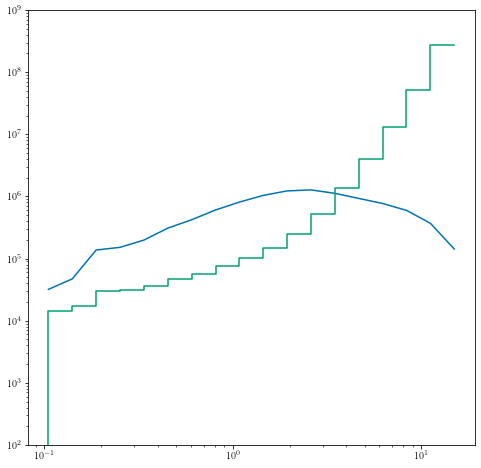

In [389]:
plt.figure(figsize=(8,8))
plt.loglog(k[1:-1], (k[1:-1]**3 * P_OIII_OIII[1:-1] * W_k_OIII[1:-1]).value / (2 * np.pi**2))
plt.loglog(k[1:-1], (k[1:-1]**3 * sigma_OIII_OIII[:-1]).value / (2 * np.pi**2), 
                              drawstyle='steps')

plt.ylim(1e2, 1e9)

### Current and upcoming surveys

In [ ]:
import matplotlib.transforms as mtransforms
import matplotlib.patches as mpatch
from matplotlib.patches import FancyBboxPatch

In [366]:
specs_CCATp = {'sigma_pix': 0.86 * (u.MJy * u.s**(1/2) / u.steradian),
               'N_det': 20 * u.dimensionless_unscaled,
               'theta_FWMH': 46.0 * u.arcsec,
               'nu_obs_min': 200.0 * u.GHz,
               'nu_obs_max': 300.0 * u.GHz,
               'delta_nu': 2.5 * u.GHz,
               't_obs': 3400 * u.hr,
               'Omega_surv': 1.7 * u.degree**2,
               'AGN Source': 'COSMOS'}

specs_HERA = {'sigma_pix': None,
               'N_det': None,
               'theta_FWMH': None,
               'nu_obs_min': 100.0 * u.GHz,
               'nu_obs_max': 200.0 * u.GHz,
               'delta_nu': 97.8 * u.kHz,
               't_obs': None,
               'Omega_surv': 1440 * u.degree**2,
               'AGN Source': None}

specs_StageII = {'sigma_pix': 0.21 * (u.MJy * u.s**(1/2) / u.steradian),
               'N_det': 16**4 * u.dimensionless_unscaled,
               'theta_FWMH': 30.1 * u.arcsec,
               'nu_obs_min': 200.0 * u.GHz,
               'nu_obs_max': 300.0 * u.GHz,
               'delta_nu': 0.4 * u.GHz,
               't_obs': 2000 * u.hr,
               'Omega_surv': 100.0 * u.degree**2,
               'AGN Source': 'DESI'}

specs_EXCLAIM = {'sigma_pix': 0.2 * (u.MJy * u.s**(1/2) / u.steradian),
               'N_det': 30 * u.dimensionless_unscaled,
               'theta_FWMH': None,
               'sigma_beam': utils.calc_sigma_beam(6, lambda_OIII, 3.0 * u.m),
               'B_nu': 40.0 * u.GHz,
               'nu_obs_min': 420.0 * u.GHz,
               'nu_obs_max': 540.0 * u.GHz,
               'delta_nu': 1000 * u.MHz,
               't_obs': 8.0 * u.hr,
               'Omega_surv': 100.0 * u.degree**2,
               'AGN Source': 'DESI'}


In [ ]:
sigma_beam_CCATp = utils.FWHM_to_sigma(specs_CCATp['theta_FWMH']) # FWHM_to_sigma(46) #arcsec
sigma_perp_CCATp = utils.calc_sigma_perp(z, sigma_beam_CCATp)
sigma_para_CCATp = utils.calc_sigma_para(z, nu_obs, specs_CCATp['delta_nu'])

In [ ]:
def add_fancy_patch_around(ax, bb, **kwargs):
    fancy = FancyBboxPatch((bb.xmin, bb.ymin), bb.width, bb.height,
                           **kwargs)
    ax.add_patch(fancy)
    return fancy

def draw_control_points_for_patches(ax):
    for patch in ax.patches:
        patch.axes.plot(*patch.get_path().vertices.T, ".",
                        c=patch.get_edgecolor())
        
def plot_box(ax, k_perp_min, k_perp_max, k_para_min, k_para_max, color):
    # Bbox object around which the fancy box will be drawn.
    bb = mtransforms.Bbox([[k_perp_min, k_para_min], [k_perp_max, k_para_max]])


    # a fancy box with round corners. pad=0.1
    fancy = add_fancy_patch_around(ax, bb, boxstyle="round,pad=0.0",
                                alpha=.2, color=color)

In [ ]:
sigma_beam_FYST = 1.22 * lambda_CII / (3 * u.m)

sigma_perp_FYST = utils.calc_sigma_perp(z, sigma_beam_FYST.decompose())
sigma_perp_HERA = utils.calc_sigma_perp(z, sigma_beam_FYST.decompose())
sigma_perp_CCATp = utils.calc_sigma_perp(z, utils.FWHM_to_sigma(specs_CCATp['theta_FWMH']))
sigma_perp_StageII = utils.calc_sigma_perp(z, utils.FWHM_to_sigma(specs_StageII['theta_FWMH']))
#sigma_perp_EXCLAIM_1 = utils.calc_sigma_perp(z, utils.FWHM_to_sigma(specs_EX['theta_FWMH']))

sigma_para_FYST = utils.calc_sigma_para(z, nu_obs, 300 * u.MHz)
sigma_para_HERA = utils.calc_sigma_para(z, nu_21cm_obs, specs_HERA['delta_nu'])
sigma_para_CCATp = utils.calc_sigma_para(z, nu_obs, specs_CCATp['delta_nu'])
sigma_para_StageII = utils.calc_sigma_para(z, nu_obs, specs_StageII['delta_nu'])
#sigma_perp_EXCLAIM_1 = utils.calc_sigma_perp(z, utils.FWHM_to_sigma(specs_CCATp['theta_FWMH']))

In [ ]:
L_perp_CCATp = (np.sqrt(Planck15.comoving_distance(z)**2 \
            * specs_CCATp['Omega_surv'])).to(u.Mpc, equivalencies=u.dimensionless_angles())
L_para_CCATp = ((const.c / Planck15.H(z)) * (100 * u.GHz) \
          * (1 + z)**2 / nu_C_II).to(u.Mpc)

L_perp_StageII = (np.sqrt(Planck15.comoving_distance(z)**2 \
            * specs_StageII['Omega_surv'])).to(u.Mpc, equivalencies=u.dimensionless_angles())
L_para_StageII = ((const.c / Planck15.H(z)) * (100 * u.GHz) \
          * (1 + z)**2 / nu_C_II).to(u.Mpc)

L_perp_HERA = (np.sqrt(Planck15.comoving_distance(z)**2 \
            * specs_HERA['Omega_surv'])).to(u.Mpc, equivalencies=u.dimensionless_angles())
L_para_HERA = ((const.c / Planck15.H(z)) * (100 * u.MHz) \
          * (1 + z)**2 / nu_21cm).to(u.Mpc)

L_perp_EXCLAIM_1 = (np.sqrt(Planck15.comoving_distance(z)**2 \
            * (100 * u.degree**2))).to(u.Mpc, equivalencies=u.dimensionless_angles())
L_para_EXCLAIM_1 = ((const.c / Planck15.H(z)) * (100 * u.GHz) \
          * (1 + z)**2 / nu_OIII).to(u.Mpc)

In [ ]:
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9']

In [ ]:
L_perp_CCATp = (np.sqrt(Planck15.comoving_distance(z)**2 \
            * specs_CCATp['Omega_surv'])).to(u.Mpc, equivalencies=u.dimensionless_angles())
L_para_CCATp = ((const.c / Planck15.H(z)) * (100 * u.GHz) \
          * (1 + z)**2 / nu_C_II).to(u.Mpc)

L_perp_FYST = (np.sqrt(Planck15.comoving_distance(z)**2 \
            * (100 * u.degree**2))).to(u.Mpc, equivalencies=u.dimensionless_angles())
L_para_FYST = ((const.c / Planck15.H(z)) * (100 * u.GHz) \
          * (1 + z)**2 / nu_C_II).to(u.Mpc)

L_perp_FYST_2 = (np.sqrt(Planck15.comoving_distance(z)**2 \
            * (100 * u.degree**2))).to(u.Mpc, equivalencies=u.dimensionless_angles())
L_para_FYST_2 = ((const.c / Planck15.H(z)) * (100 * u.GHz) \
          * (1 + z)**2 / nu_C_II).to(u.Mpc)

print(L_perp_CCATp, L_para_CCATp)
print(L_perp_FYST, L_para_FYST)
print(L_perp_FYST_2, L_para_FYST_2)

In [ ]:
print('CCATp:')
print(L_perp_CCATp, L_para_CCATp)

print('StageII:')
print(L_perp_StageII, L_para_StageII)

print('HERA:')
print(L_perp_HERA, L_para_HERA)

print('Box:')
print(box_size * u.Mpc, box_size * u.Mpc)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12, 12))

k_perp_min_CCATp = (2 * np.pi) / L_perp_21cm
k_perp_min_StageII = (2 * np.pi) / L_perp_StageII
k_perp_min_HERA = (2 * np.pi) / L_perp_HERA
k_perp_min_EXCLAIM_1 = (2 * np.pi) / L_perp_EXCLAIM_1
#k_perp_min_EXCLAIM_2 = (2 * np.pi) / L_perp_21cm

k_para_min_CCATp = (2 * np.pi) / L_para_21cm
k_para_min_StageII = (2 * np.pi) / L_para_StageII
k_para_min_HERA = (2 * np.pi) / L_para_HERA
k_para_min_EXCLAIM_1 = (2 * np.pi) / L_para_EXCLAIM_1
#k_para_min_EXCLAIM_2 = (2 * np.pi) / L_para_EXCLAIM_2

k_perp_max_CCATp = 1 / sigma_perp_CCATp
k_perp_max_StageII = 1 / sigma_perp_StageII
k_perp_max_HERA = 1 / sigma_perp_HERA
#k_perp_max_EXCLAIM_1 = 1 / sigma_perp_EXCLAIM_1
#k_perp_max_EXCLAIM_2 = 1 / sigma_perp_EXCLAIM_2

k_para_max_CCATp = 1 / sigma_para_CCATp
k_para_max_StageII = 1 / sigma_para_StageII
k_para_max_HERA = 1 / sigma_para_HERA
#k_perp_max_EXCLAIM_1 = 1 / sigma_para_EXCLAIM_1
#k_perp_max_EXCLAIM_2 = 1 / sigma_para_EXCLAIM_2

plot_box(ax, k_perp_min_CCATp.value, k_perp_max_CCATp.value,
                             k_para_min_CCATp.value, k_para_max_CCATp.value, colors[0])
plot_box(ax, k_perp_min_StageII.value, k_perp_max_StageII.value, 
                             k_para_min_StageII.value, k_para_max_StageII.value, colors[1])
#plot_box(ax, k_perp_min_box.value, k_perp_max_box.value, k_para_min_box.value,
#                             k_para_max_box.value, colors[2])
plot_box(ax, k_perp_min_HERA.value, k_perp_max_HERA.value,
                             k_para_min_HERA.value, k_para_max_HERA.value, colors[3])
plot_box(ax, k_perp_min_box.value, k_perp_max_StageII.value, k_para_min_box.value,
                     k_para_max_StageII.value, colors[4])



setup = ax.set(xlim=(0, 2), ylim=(0, 2), aspect=1)
x_l = ax.set_xlabel(r'$k_{\perp}$', fontsize=20)
y_l = ax.set_ylabel(r'$k_{\parallel}$', fontsize=20)

title = ax.set_title('Survey extents in $k$-space', fontsize=20)
leg = ax.legend(['CCATp', 'FYST (or Stage II)', 'HERA', 'box w/ FYST resolution'])

In [ ]:
def calc_V_surv_generic_check(z, nu_rest, Omega_surv, B_nu):
    A_s = Omega_surv  
    B_nu = B_nu
    r = Planck15.comoving_distance(z)
    y = (const.c * (1 + z)**2) / (Planck15.H(z) * nu_rest)
    
    V = r**2 * y * A_s * B_nu * Planck15.h**3
    
    return V.to(u.Mpc**3, equivalencies=u.dimensionless_angles())

In [459]:
b_0

27.938048656426545

# Fitting

In [456]:
k_indices = [6]
biases = utils.extract_bias(k_indices, spectra_fields[1], density_pspec_log)
b_0, b_1, b_2 = biases[0:3]
data = utils.fetch_data(spectra_fields[0], k_indices, spectra_fields[1])

sigma_CIIxOIII = 84.0 * 2 * np.pi**2 / k_log[k_indices]**3
variances = [var_21cm_CII, var_21cm_OIII, var_CII_OIII, b_0 * .25]

# N = analysis.estimate_errors(data, frac_error=.1)
N = analysis.create_noise_matrix(k_indices, variances)

p_names = np.asarray(['b_i','b_j', 'b_k', 'P_m'])
p_vals = np.asarray([b_0, b_1, b_2, density_pspec_log], dtype=object)
model_params = dict(zip(p_names, p_vals))

ndim = utils.choose_params(model_params, k_indices).size

model = models.ScalarBias(k=spectra_fields[0], params=model_params)
#model_nb_2auto = models.ScalarBias_2auto_3cross(k=k, params=model_params)

k = k_log

### Least Square Estimators

$\sigma_f = \sqrt{\left( \frac{\partial f}{\partial x} \right)^2 \sigma_x^2}$

with $f(x) = e^x$ and $x=\ln{P_m}$, yielding,

$\sigma_{P_m} = \sqrt{\left( \frac{\partial }{\partial(\ln{P_m})}\left[ e^{\ln{P_m}} \right] \right)^2 \sigma_{\ln{P_m}}^2} $

$= \sqrt{\left(e^{\ln{P_m}}\right)^2 \sigma_{\ln{P_m}}^2}$
$= \sqrt{P^2_m \sigma_{\ln{P_m}}^2}$

$\sigma_{P_m} = P_m \sigma_{\ln{P_m}}$

### MCMC's

In [462]:
mcmc_results = fitting.recover_params_mcmc(k, k_indices, spectra_fields[1], model,
                                    density_pspec_log, priors='gaussian',
                                    positivity=True, priors_width=.1)

running mcmc with the following settings:
fitting data from k:  [6]
prior is:  gaussian
prior width is:  0.1
positivity prior is:  True
pdf is:  gaussian
no backend initialized


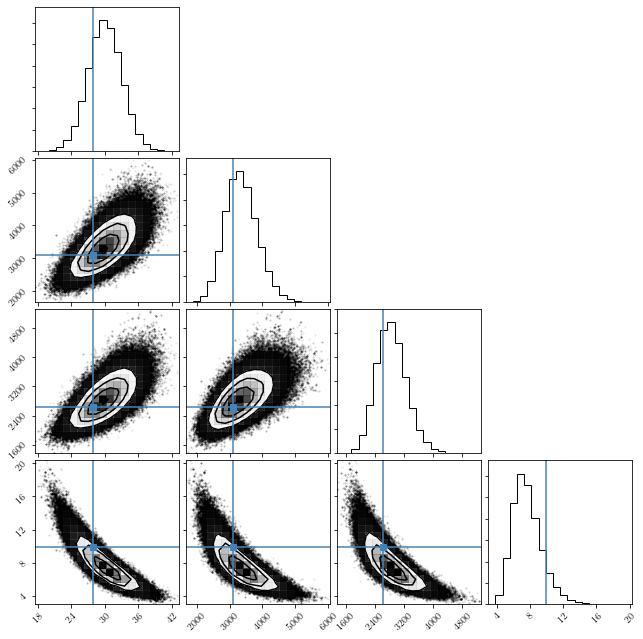

In [463]:
corner_results = corner.corner(mcmc_results[0][0],
                            truths=utils.choose_params(model_params, k_indices))

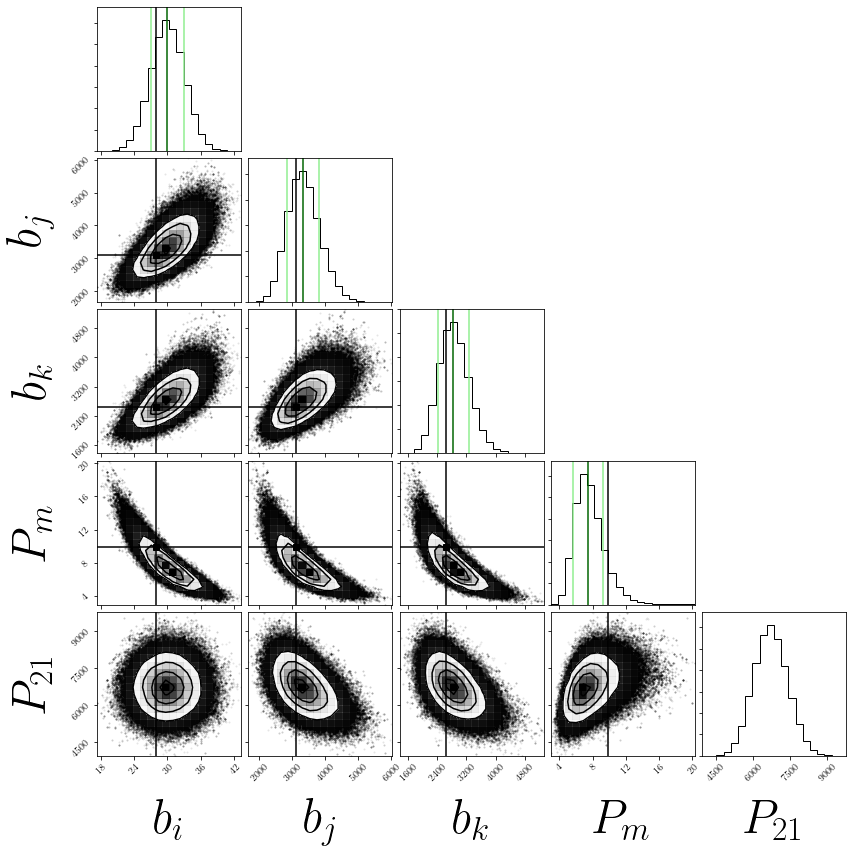

In [465]:
ndim_corner = ndim + 1

samples = mcmc_results[0][0]
samples_00 = analysis.add_P(samples, k_indices, (0,0))

corner_gaussian = corner.corner(samples_00,
            truths=[*utils.choose_params(mcmc_results[1], k_indices), *spectra_fields[0][k_indices]],
            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$', r'$P_{21}$'],
            label_kwargs={'fontsize':48}, truth_color='black')

axes = np.array(corner_gaussian.axes).reshape((ndim_corner, ndim_corner))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(np.median(samples[:,i]), color='darkgreen')
    ax.axvline(np.median(samples[:,i]) - np.sqrt(samples[:,i].var()), color="lightgreen")
    ax.axvline(np.median(samples[:,i]) + np.sqrt(samples[:,i].var()), color="lightgreen")


In [466]:
3 * I_avg_CII_Lidz

<Quantity 4019.25114058 Jy / sr>